# Dependency

In [ ]:
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 4.7 MB/s eta 0:00:00


# Mean Field Approximation

|   iter    |  target   | pairwi... | unary_... |
-------------------------------------------------
| 1         | -0.2022   | 0.4229    | 7.483     |
| 2         | -0.123    | 0.01011   | 3.721     |
| 3         | -0.2905   | 0.1553    | 1.831     |
| 4         | -0.1787   | 0.1944    | 4.11      |
| 5         | -0.4987   | 0.4028    | 5.849     |
| 6         | -0.3147   | 0.425     | 7.167     |
| 7         | -0.08413  | 0.2124    | 8.903     |
| 8         | -0.07019  | 0.03711   | 7.034     |
| 9         | -0.5316   | 0.4231    | 6.028     |
| 10        | -0.2172   | 0.149     | 2.783     |
| 11        | -0.08367  | 0.2444    | 8.394     |
| 12        | -0.841    | 0.8178    | 8.673     |
| 13        | -0.0899   | 0.1578    | 6.659     |
| 14        | -0.08654  | 0.0588    | 7.041     |
| 15        | -0.07371  | 0.02402   | 7.962     |
| 16        | -0.08889  | 0.01      | 9.428     |
| 17        | -0.8335   | 0.7658    | 3.5       |
| 18        | -0.1017   | 0.4163    | 9.998     |


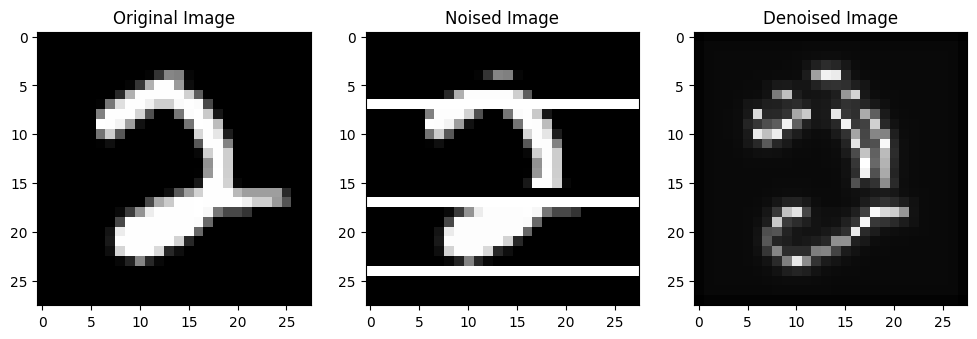

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import transforms
from bayes_opt import BayesianOptimization

# MNIST 데이터셋을 로드
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1, shuffle=True)

# 이미지에 salt and pepper 노이즈를 추가하는 함수를 정의
def add_salt_and_pepper_noise(image, amount, s_vs_p):
    noisy = image.clone().numpy()
    num_salt = np.ceil(amount * image.numel() * s_vs_p)
    num_pepper = np.ceil(amount * image.numel() * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[coords] = 1
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[coords] = 0
    return torch.tensor(noisy, dtype=torch.float32)

# CRF를 위한 Mean Field Inference 단계를 정의
def mean_field_inference_step(unary_potentials, pairwise_potential_strength, num_iterations):
    labels = unary_potentials.clone()
    conv_weight = pairwise_potential_strength * torch.ones(1, 1, 3, 3)
    for _ in range(num_iterations):
        labels_smoothed = torch.nn.functional.conv2d(labels.unsqueeze(0).unsqueeze(0),
                                                     weight=conv_weight,
                                                     padding=1)
        labels = unary_potentials + labels_smoothed.squeeze(0).squeeze(0)
        labels = torch.sigmoid(labels)  # 레이블을 [0, 1] 범위로 정규화
    return labels

# Bayesian Optimization을 위한 목적 함수를 정의
def objective(unary_potential_strength, pairwise_potential_strength, ):
    total_error = 0.0
    num_images = 5
    for i, (images, _) in enumerate(train_loader):
        if i >= num_images:
            break
        original_image = images[0][0]
        noisy_image = add_salt_and_pepper_noise(original_image, 0.005, 0.5)
        unary_potentials = -unary_potential_strength * (noisy_image - 0.5).pow(2)
        denoised_image = mean_field_inference_step(unary_potentials, pairwise_potential_strength, 15)
        total_error += torch.mean((original_image - denoised_image) ** 2).item()
    return -total_error / num_images  # 목적 함수를 최소화하려고 하므로 평균 오류의 음수를 반환

# Bayesian Optimization에서 하이퍼파라미터의 범위를 설정
params = {
    'unary_potential_strength': (1, 10),
    'pairwise_potential_strength': (0.01, 1)
}

# Bayesian optimization을 초기화하고 수행
optimizer = BayesianOptimization(f=objective, pbounds=params, random_state=1)
optimizer.maximize(init_points=10, n_iter=40)

# 최적의 하이퍼파라미터를 추출
best_params = optimizer.max['params']

# 최적화된 파라미터를 사용하여 이미지를 denoise하고 결과를 시각화
for images, _ in train_loader:
    original_image = images[0][0]
    noisy_image = add_salt_and_pepper_noise(original_image, 0.005, 0.5)
    unary_potentials = -best_params['unary_potential_strength'] * (noisy_image - 0.5).pow(2)
    denoised_image = mean_field_inference_step(unary_potentials, best_params['pairwise_potential_strength'], 15)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.numpy(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_image.numpy(), cmap='gray')
    plt.title('Noised Image')
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image.detach().numpy(), cmap='gray')
    plt.title('Denoised Image')
    plt.show()
    break  # 시연을 위해 첫 번째 이미지만 처리

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def add_salt_and_pepper_noise(image, amount=0.005, s_vs_p=0.5):
    noisy = image.clone().detach().numpy()
    num_salt = np.ceil(amount * image.numel() * s_vs_p).astype(int)
    num_pepper = np.ceil(amount * image.numel() * (1. - s_vs_p)).astype(int)

    for _ in range(num_salt):
        x_coord = np.random.randint(0, image.shape[1])  # (C, H, W)
        y_coord = np.random.randint(0, image.shape[2])
        noisy[0][x_coord][y_coord] = 1

    for _ in range(num_pepper):
        x_coord = np.random.randint(0, image.shape[1])
        y_coord = np.random.randint(0, image.shape[2])
        noisy[0][x_coord][y_coord] = 0

    return torch.tensor(noisy, dtype=torch.float32)

def mean_field_inference_step(unary_potentials, pairwise_potential_strength, num_iterations):
    labels = unary_potentials.clone()
    conv_weight = pairwise_potential_strength * torch.ones(1, 1, 3, 3)
    for _ in range(num_iterations):
        labels_smoothed = torch.nn.functional.conv2d(labels,
                                                     weight=conv_weight,
                                                     padding=1)
        labels = unary_potentials + labels_smoothed.squeeze(0).squeeze(0)
        labels = torch.sigmoid(labels)  # 레이블을 [0, 1] 범위로 정규화
    return labels

# 데이터 로드
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# 모델, 손실 함수, optimizer 초기화
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

from tqdm import tqdm

# 학습 루프
for epoch in range(2):  # 전체 데이터셋을 2번 반복
    total_correct = 0
    total_samples = 0

    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # 이미지에 noise 추가 및 denoise
        noisy_images = torch.stack([add_salt_and_pepper_noise(img, 0.005, 0.5) for img in images])
        denoised_images = torch.stack([mean_field_inference_step(-best_params['unary_potential_strength'] * (img - 0.5).pow(2), best_params['pairwise_potential_strength'], 15) for img in noisy_images])

        # 모델을 통해 예측값 계산
        outputs = model(denoised_images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 정확도 계산
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # 10번의 루프마다 정확도 출력
        if (i + 1) % 10 == 0:
            current_accuracy = 100 * total_correct / total_samples
            print(f'\tBatch {i+1}, Epoch [{epoch+1}/2], Loss: {round(loss.item(), 4)}, Accuracy: {current_accuracy:.2f}%')

    # 에포크의 끝에서 전체 정확도 출력
    epoch_accuracy = 100 * total_correct / total_samples
    print(f'End of Epoch [{epoch+1}/2], Loss: {round(loss.item(), 4)}, Total Accuracy: {epoch_accuracy:.2f}%')
    print()

  1%|          | 11/938 [00:01<02:05,  7.37it/s]

	Batch 10, Epoch [1/2], Loss: 2.1958, Accuracy: 16.88%


  2%|▏         | 21/938 [00:03<02:40,  5.73it/s]

	Batch 20, Epoch [1/2], Loss: 1.8185, Accuracy: 29.69%


  3%|▎         | 30/938 [00:04<03:08,  4.82it/s]

	Batch 30, Epoch [1/2], Loss: 1.3032, Accuracy: 38.75%


  4%|▍         | 41/938 [00:06<02:07,  7.02it/s]

	Batch 40, Epoch [1/2], Loss: 1.0403, Accuracy: 45.70%


  5%|▌         | 51/938 [00:08<01:54,  7.74it/s]

	Batch 50, Epoch [1/2], Loss: 0.9304, Accuracy: 51.22%


  7%|▋         | 61/938 [00:09<02:00,  7.28it/s]

	Batch 60, Epoch [1/2], Loss: 0.6827, Accuracy: 55.39%


  8%|▊         | 71/938 [00:10<01:51,  7.80it/s]

	Batch 70, Epoch [1/2], Loss: 0.4494, Accuracy: 58.84%


  9%|▊         | 81/938 [00:12<01:51,  7.68it/s]

	Batch 80, Epoch [1/2], Loss: 0.5868, Accuracy: 61.50%


 10%|▉         | 91/938 [00:13<01:53,  7.43it/s]

	Batch 90, Epoch [1/2], Loss: 0.7586, Accuracy: 63.80%


 11%|█         | 101/938 [00:14<01:50,  7.56it/s]

	Batch 100, Epoch [1/2], Loss: 0.5155, Accuracy: 65.91%


 12%|█▏        | 111/938 [00:15<01:46,  7.78it/s]

	Batch 110, Epoch [1/2], Loss: 0.6251, Accuracy: 67.80%


 13%|█▎        | 121/938 [00:17<02:40,  5.10it/s]

	Batch 120, Epoch [1/2], Loss: 0.4569, Accuracy: 69.13%


 14%|█▍        | 131/938 [00:19<02:23,  5.62it/s]

	Batch 130, Epoch [1/2], Loss: 0.3824, Accuracy: 70.29%


 15%|█▌        | 141/938 [00:21<01:41,  7.87it/s]

	Batch 140, Epoch [1/2], Loss: 0.2734, Accuracy: 71.36%


 16%|█▌        | 151/938 [00:22<01:51,  7.06it/s]

	Batch 150, Epoch [1/2], Loss: 0.5489, Accuracy: 72.35%


 17%|█▋        | 161/938 [00:23<01:49,  7.07it/s]

	Batch 160, Epoch [1/2], Loss: 0.3922, Accuracy: 73.29%


 18%|█▊        | 171/938 [00:25<01:42,  7.45it/s]

	Batch 170, Epoch [1/2], Loss: 0.4173, Accuracy: 74.06%


 19%|█▉        | 181/938 [00:26<01:41,  7.44it/s]

	Batch 180, Epoch [1/2], Loss: 0.5187, Accuracy: 74.70%


 20%|██        | 191/938 [00:27<01:40,  7.47it/s]

	Batch 190, Epoch [1/2], Loss: 0.2561, Accuracy: 75.39%


 21%|██▏       | 201/938 [00:29<01:35,  7.73it/s]

	Batch 200, Epoch [1/2], Loss: 0.2438, Accuracy: 76.09%


 22%|██▏       | 210/938 [00:30<02:13,  5.45it/s]

	Batch 210, Epoch [1/2], Loss: 0.3635, Accuracy: 76.58%


 23%|██▎       | 220/938 [00:32<02:26,  4.91it/s]

	Batch 220, Epoch [1/2], Loss: 0.2109, Accuracy: 77.17%


 25%|██▍       | 231/938 [00:34<01:35,  7.41it/s]

	Batch 230, Epoch [1/2], Loss: 0.2914, Accuracy: 77.64%


 26%|██▌       | 241/938 [00:36<02:15,  5.14it/s]

	Batch 240, Epoch [1/2], Loss: 0.4912, Accuracy: 78.10%


 27%|██▋       | 251/938 [00:37<01:29,  7.68it/s]

	Batch 250, Epoch [1/2], Loss: 0.4457, Accuracy: 78.52%


 28%|██▊       | 261/938 [00:39<01:31,  7.37it/s]

	Batch 260, Epoch [1/2], Loss: 0.3496, Accuracy: 78.92%


 29%|██▉       | 271/938 [00:40<01:28,  7.53it/s]

	Batch 270, Epoch [1/2], Loss: 0.2656, Accuracy: 79.27%


 30%|██▉       | 281/938 [00:41<01:25,  7.65it/s]

	Batch 280, Epoch [1/2], Loss: 0.5349, Accuracy: 79.66%


 31%|███       | 291/938 [00:43<01:24,  7.63it/s]

	Batch 290, Epoch [1/2], Loss: 0.1992, Accuracy: 80.01%


 32%|███▏      | 301/938 [00:45<02:03,  5.16it/s]

	Batch 300, Epoch [1/2], Loss: 0.1774, Accuracy: 80.38%


 33%|███▎      | 311/938 [00:47<01:52,  5.57it/s]

	Batch 310, Epoch [1/2], Loss: 0.3917, Accuracy: 80.74%


 34%|███▍      | 321/938 [00:48<01:22,  7.48it/s]

	Batch 320, Epoch [1/2], Loss: 0.4239, Accuracy: 81.03%


 35%|███▌      | 331/938 [00:49<01:26,  7.03it/s]

	Batch 330, Epoch [1/2], Loss: 0.3728, Accuracy: 81.34%


 36%|███▋      | 341/938 [00:51<01:20,  7.46it/s]

	Batch 340, Epoch [1/2], Loss: 0.115, Accuracy: 81.65%


 37%|███▋      | 351/938 [00:52<01:26,  6.78it/s]

	Batch 350, Epoch [1/2], Loss: 0.3065, Accuracy: 81.95%


 38%|███▊      | 361/938 [00:54<01:15,  7.61it/s]

	Batch 360, Epoch [1/2], Loss: 0.1991, Accuracy: 82.24%


 40%|███▉      | 371/938 [00:55<01:14,  7.59it/s]

	Batch 370, Epoch [1/2], Loss: 0.1742, Accuracy: 82.51%


 41%|████      | 381/938 [00:56<01:13,  7.54it/s]

	Batch 380, Epoch [1/2], Loss: 0.2138, Accuracy: 82.80%


 42%|████▏     | 391/938 [00:58<01:45,  5.19it/s]

	Batch 390, Epoch [1/2], Loss: 0.2258, Accuracy: 83.02%


 43%|████▎     | 401/938 [01:00<01:47,  5.01it/s]

	Batch 400, Epoch [1/2], Loss: 0.1881, Accuracy: 83.22%


 44%|████▍     | 411/938 [01:01<01:09,  7.60it/s]

	Batch 410, Epoch [1/2], Loss: 0.2396, Accuracy: 83.44%


 45%|████▍     | 421/938 [01:03<01:08,  7.58it/s]

	Batch 420, Epoch [1/2], Loss: 0.1875, Accuracy: 83.63%


 46%|████▌     | 431/938 [01:04<01:08,  7.35it/s]

	Batch 430, Epoch [1/2], Loss: 0.2458, Accuracy: 83.80%


 47%|████▋     | 441/938 [01:05<01:06,  7.49it/s]

	Batch 440, Epoch [1/2], Loss: 0.2285, Accuracy: 84.00%


 48%|████▊     | 451/938 [01:07<01:06,  7.30it/s]

	Batch 450, Epoch [1/2], Loss: 0.3688, Accuracy: 84.17%


 49%|████▉     | 461/938 [01:08<01:03,  7.53it/s]

	Batch 460, Epoch [1/2], Loss: 0.3812, Accuracy: 84.37%


 50%|█████     | 471/938 [01:10<01:01,  7.56it/s]

	Batch 470, Epoch [1/2], Loss: 0.1523, Accuracy: 84.56%


 51%|█████     | 480/938 [01:11<01:26,  5.30it/s]

	Batch 480, Epoch [1/2], Loss: 0.2117, Accuracy: 84.74%


 52%|█████▏    | 490/938 [01:13<01:27,  5.12it/s]

	Batch 490, Epoch [1/2], Loss: 0.1038, Accuracy: 84.89%


 53%|█████▎    | 501/938 [01:15<01:00,  7.22it/s]

	Batch 500, Epoch [1/2], Loss: 0.125, Accuracy: 85.03%


 54%|█████▍    | 511/938 [01:16<00:56,  7.51it/s]

	Batch 510, Epoch [1/2], Loss: 0.1383, Accuracy: 85.19%


 56%|█████▌    | 521/938 [01:17<00:54,  7.59it/s]

	Batch 520, Epoch [1/2], Loss: 0.1667, Accuracy: 85.34%


 57%|█████▋    | 531/938 [01:19<00:55,  7.29it/s]

	Batch 530, Epoch [1/2], Loss: 0.1304, Accuracy: 85.50%


 58%|█████▊    | 541/938 [01:20<00:51,  7.65it/s]

	Batch 540, Epoch [1/2], Loss: 0.2092, Accuracy: 85.61%


 59%|█████▊    | 551/938 [01:21<00:52,  7.42it/s]

	Batch 550, Epoch [1/2], Loss: 0.1516, Accuracy: 85.74%


 60%|█████▉    | 561/938 [01:23<00:49,  7.62it/s]

	Batch 560, Epoch [1/2], Loss: 0.1308, Accuracy: 85.89%


 61%|██████    | 571/938 [01:24<01:02,  5.85it/s]

	Batch 570, Epoch [1/2], Loss: 0.1104, Accuracy: 86.02%


 62%|██████▏   | 581/938 [01:26<01:10,  5.09it/s]

	Batch 580, Epoch [1/2], Loss: 0.0734, Accuracy: 86.15%


 63%|██████▎   | 591/938 [01:28<00:51,  6.74it/s]

	Batch 590, Epoch [1/2], Loss: 0.2416, Accuracy: 86.25%


 64%|██████▍   | 601/938 [01:29<00:46,  7.17it/s]

	Batch 600, Epoch [1/2], Loss: 0.2133, Accuracy: 86.35%


 65%|██████▌   | 611/938 [01:31<00:42,  7.64it/s]

	Batch 610, Epoch [1/2], Loss: 0.1505, Accuracy: 86.49%


 66%|██████▌   | 621/938 [01:33<00:50,  6.34it/s]

	Batch 620, Epoch [1/2], Loss: 0.0605, Accuracy: 86.61%


 67%|██████▋   | 631/938 [01:34<00:41,  7.41it/s]

	Batch 630, Epoch [1/2], Loss: 0.2431, Accuracy: 86.71%


 68%|██████▊   | 641/938 [01:35<00:39,  7.44it/s]

	Batch 640, Epoch [1/2], Loss: 0.2133, Accuracy: 86.85%


 69%|██████▉   | 651/938 [01:37<00:39,  7.20it/s]

	Batch 650, Epoch [1/2], Loss: 0.3986, Accuracy: 86.97%


 70%|███████   | 661/938 [01:38<00:54,  5.08it/s]

	Batch 660, Epoch [1/2], Loss: 0.1949, Accuracy: 87.08%


 71%|███████▏  | 670/938 [01:40<00:54,  4.95it/s]

	Batch 670, Epoch [1/2], Loss: 0.0845, Accuracy: 87.21%


 73%|███████▎  | 681/938 [01:42<00:36,  7.05it/s]

	Batch 680, Epoch [1/2], Loss: 0.1756, Accuracy: 87.31%


 74%|███████▎  | 691/938 [01:44<00:35,  6.94it/s]

	Batch 690, Epoch [1/2], Loss: 0.5109, Accuracy: 87.38%


 75%|███████▍  | 701/938 [01:45<00:33,  7.17it/s]

	Batch 700, Epoch [1/2], Loss: 0.1492, Accuracy: 87.45%


 76%|███████▌  | 711/938 [01:46<00:31,  7.17it/s]

	Batch 710, Epoch [1/2], Loss: 0.1799, Accuracy: 87.53%


 77%|███████▋  | 721/938 [01:48<00:29,  7.38it/s]

	Batch 720, Epoch [1/2], Loss: 0.1916, Accuracy: 87.62%


 78%|███████▊  | 731/938 [01:50<00:46,  4.43it/s]

	Batch 730, Epoch [1/2], Loss: 0.1039, Accuracy: 87.73%


 79%|███████▉  | 740/938 [01:51<00:37,  5.32it/s]

	Batch 740, Epoch [1/2], Loss: 0.1361, Accuracy: 87.82%


 80%|███████▉  | 750/938 [01:53<00:37,  5.02it/s]

	Batch 750, Epoch [1/2], Loss: 0.1147, Accuracy: 87.92%


 81%|████████  | 761/938 [01:55<00:26,  6.68it/s]

	Batch 760, Epoch [1/2], Loss: 0.4256, Accuracy: 88.00%


 82%|████████▏ | 771/938 [01:57<00:23,  7.21it/s]

	Batch 770, Epoch [1/2], Loss: 0.1961, Accuracy: 88.07%


 83%|████████▎ | 781/938 [01:58<00:21,  7.21it/s]

	Batch 780, Epoch [1/2], Loss: 0.0902, Accuracy: 88.16%


 84%|████████▍ | 791/938 [02:00<00:19,  7.41it/s]

	Batch 790, Epoch [1/2], Loss: 0.0711, Accuracy: 88.25%


 85%|████████▌ | 801/938 [02:01<00:19,  7.12it/s]

	Batch 800, Epoch [1/2], Loss: 0.1768, Accuracy: 88.34%


 86%|████████▋ | 811/938 [02:02<00:17,  7.20it/s]

	Batch 810, Epoch [1/2], Loss: 0.2168, Accuracy: 88.43%


 88%|████████▊ | 821/938 [02:04<00:15,  7.34it/s]

	Batch 820, Epoch [1/2], Loss: 0.1093, Accuracy: 88.51%


 88%|████████▊ | 830/938 [02:05<00:18,  5.91it/s]

	Batch 830, Epoch [1/2], Loss: 0.4507, Accuracy: 88.60%


 90%|████████▉ | 840/938 [02:07<00:20,  4.80it/s]

	Batch 840, Epoch [1/2], Loss: 0.0968, Accuracy: 88.69%


 91%|█████████ | 851/938 [02:09<00:12,  6.88it/s]

	Batch 850, Epoch [1/2], Loss: 0.1528, Accuracy: 88.76%


 92%|█████████▏| 861/938 [02:11<00:10,  7.24it/s]

	Batch 860, Epoch [1/2], Loss: 0.0957, Accuracy: 88.84%


 93%|█████████▎| 871/938 [02:12<00:09,  7.36it/s]

	Batch 870, Epoch [1/2], Loss: 0.13, Accuracy: 88.91%


 94%|█████████▍| 881/938 [02:13<00:07,  7.35it/s]

	Batch 880, Epoch [1/2], Loss: 0.1017, Accuracy: 88.96%


 95%|█████████▍| 891/938 [02:15<00:06,  7.43it/s]

	Batch 890, Epoch [1/2], Loss: 0.0515, Accuracy: 89.05%


 96%|█████████▌| 901/938 [02:16<00:05,  7.17it/s]

	Batch 900, Epoch [1/2], Loss: 0.1098, Accuracy: 89.12%


 97%|█████████▋| 911/938 [02:17<00:03,  6.90it/s]

	Batch 910, Epoch [1/2], Loss: 0.1055, Accuracy: 89.18%


 98%|█████████▊| 920/938 [02:19<00:03,  5.86it/s]

	Batch 920, Epoch [1/2], Loss: 0.1512, Accuracy: 89.24%


 99%|█████████▉| 930/938 [02:21<00:01,  4.98it/s]

	Batch 930, Epoch [1/2], Loss: 0.186, Accuracy: 89.31%


100%|██████████| 938/938 [02:23<00:00,  6.52it/s]


End of Epoch [1/2], Loss: 0.1609, Total Accuracy: 89.35%



  1%|          | 11/938 [00:02<02:07,  7.27it/s]

	Batch 10, Epoch [2/2], Loss: 0.1166, Accuracy: 96.09%


  2%|▏         | 21/938 [00:03<02:05,  7.30it/s]

	Batch 20, Epoch [2/2], Loss: 0.0749, Accuracy: 95.47%


  3%|▎         | 31/938 [00:04<01:58,  7.64it/s]

	Batch 30, Epoch [2/2], Loss: 0.1994, Accuracy: 95.36%


  4%|▍         | 41/938 [00:06<01:59,  7.49it/s]

	Batch 40, Epoch [2/2], Loss: 0.1208, Accuracy: 95.35%


  5%|▌         | 51/938 [00:07<02:11,  6.73it/s]

	Batch 50, Epoch [2/2], Loss: 0.1736, Accuracy: 95.62%


  7%|▋         | 61/938 [00:09<02:09,  6.78it/s]

	Batch 60, Epoch [2/2], Loss: 0.1459, Accuracy: 95.21%


  7%|▋         | 70/938 [00:10<02:49,  5.13it/s]

	Batch 70, Epoch [2/2], Loss: 0.1591, Accuracy: 95.29%


  9%|▊         | 81/938 [00:13<02:26,  5.86it/s]

	Batch 80, Epoch [2/2], Loss: 0.1025, Accuracy: 95.35%


 10%|▉         | 91/938 [00:14<01:53,  7.47it/s]

	Batch 90, Epoch [2/2], Loss: 0.2138, Accuracy: 95.40%


 11%|█         | 101/938 [00:15<01:51,  7.48it/s]

	Batch 100, Epoch [2/2], Loss: 0.228, Accuracy: 95.41%


 12%|█▏        | 111/938 [00:17<01:58,  7.00it/s]

	Batch 110, Epoch [2/2], Loss: 0.1005, Accuracy: 95.36%


 13%|█▎        | 121/938 [00:18<01:48,  7.56it/s]

	Batch 120, Epoch [2/2], Loss: 0.1577, Accuracy: 95.40%


 14%|█▍        | 131/938 [00:19<01:46,  7.59it/s]

	Batch 130, Epoch [2/2], Loss: 0.0616, Accuracy: 95.36%


 15%|█▌        | 141/938 [00:21<01:44,  7.61it/s]

	Batch 140, Epoch [2/2], Loss: 0.1967, Accuracy: 95.30%


 16%|█▌        | 151/938 [00:22<01:46,  7.42it/s]

	Batch 150, Epoch [2/2], Loss: 0.2162, Accuracy: 95.34%


 17%|█▋        | 160/938 [00:24<02:31,  5.14it/s]

	Batch 160, Epoch [2/2], Loss: 0.1624, Accuracy: 95.38%


 18%|█▊        | 171/938 [00:26<02:27,  5.21it/s]

	Batch 170, Epoch [2/2], Loss: 0.1652, Accuracy: 95.43%


 19%|█▉        | 181/938 [00:27<01:42,  7.37it/s]

	Batch 180, Epoch [2/2], Loss: 0.2666, Accuracy: 95.41%


 20%|██        | 191/938 [00:29<01:38,  7.62it/s]

	Batch 190, Epoch [2/2], Loss: 0.1112, Accuracy: 95.48%


 21%|██▏       | 201/938 [00:30<01:37,  7.59it/s]

	Batch 200, Epoch [2/2], Loss: 0.0982, Accuracy: 95.49%


 22%|██▏       | 211/938 [00:31<01:38,  7.40it/s]

	Batch 210, Epoch [2/2], Loss: 0.1007, Accuracy: 95.59%


 24%|██▎       | 221/938 [00:33<01:35,  7.50it/s]

	Batch 220, Epoch [2/2], Loss: 0.0628, Accuracy: 95.62%


 25%|██▍       | 231/938 [00:34<01:34,  7.44it/s]

	Batch 230, Epoch [2/2], Loss: 0.1761, Accuracy: 95.67%


 26%|██▌       | 241/938 [00:35<01:37,  7.18it/s]

	Batch 240, Epoch [2/2], Loss: 0.1435, Accuracy: 95.68%


 27%|██▋       | 250/938 [00:37<02:09,  5.32it/s]

	Batch 250, Epoch [2/2], Loss: 0.0789, Accuracy: 95.73%


 28%|██▊       | 261/938 [00:39<02:23,  4.72it/s]

	Batch 260, Epoch [2/2], Loss: 0.2096, Accuracy: 95.81%


 29%|██▉       | 271/938 [00:41<02:23,  4.65it/s]

	Batch 270, Epoch [2/2], Loss: 0.0504, Accuracy: 95.82%


 30%|██▉       | 280/938 [00:43<02:29,  4.40it/s]

	Batch 280, Epoch [2/2], Loss: 0.144, Accuracy: 95.79%


 31%|███       | 291/938 [00:45<01:43,  6.23it/s]

	Batch 290, Epoch [2/2], Loss: 0.1324, Accuracy: 95.80%


 32%|███▏      | 301/938 [00:47<01:24,  7.57it/s]

	Batch 300, Epoch [2/2], Loss: 0.1615, Accuracy: 95.78%


 33%|███▎      | 311/938 [00:48<01:25,  7.30it/s]

	Batch 310, Epoch [2/2], Loss: 0.0963, Accuracy: 95.81%


 34%|███▍      | 321/938 [00:49<01:21,  7.61it/s]

	Batch 320, Epoch [2/2], Loss: 0.0515, Accuracy: 95.82%


 35%|███▌      | 331/938 [00:51<01:18,  7.70it/s]

	Batch 330, Epoch [2/2], Loss: 0.0771, Accuracy: 95.82%


 36%|███▋      | 341/938 [00:52<01:20,  7.44it/s]

	Batch 340, Epoch [2/2], Loss: 0.0693, Accuracy: 95.83%


 37%|███▋      | 351/938 [00:53<01:21,  7.22it/s]

	Batch 350, Epoch [2/2], Loss: 0.1329, Accuracy: 95.81%


 38%|███▊      | 361/938 [00:55<01:53,  5.10it/s]

	Batch 360, Epoch [2/2], Loss: 0.1054, Accuracy: 95.85%


 40%|███▉      | 371/938 [00:57<01:37,  5.79it/s]

	Batch 370, Epoch [2/2], Loss: 0.0945, Accuracy: 95.87%


 41%|████      | 381/938 [00:59<01:18,  7.10it/s]

	Batch 380, Epoch [2/2], Loss: 0.0905, Accuracy: 95.88%


 42%|████▏     | 391/938 [01:00<01:16,  7.12it/s]

	Batch 390, Epoch [2/2], Loss: 0.0952, Accuracy: 95.90%


 43%|████▎     | 401/938 [01:02<01:12,  7.41it/s]

	Batch 400, Epoch [2/2], Loss: 0.1694, Accuracy: 95.91%


 44%|████▍     | 411/938 [01:03<01:12,  7.23it/s]

	Batch 410, Epoch [2/2], Loss: 0.0693, Accuracy: 95.95%


 45%|████▍     | 421/938 [01:04<01:15,  6.87it/s]

	Batch 420, Epoch [2/2], Loss: 0.0744, Accuracy: 95.98%


 46%|████▌     | 431/938 [01:06<01:07,  7.48it/s]

	Batch 430, Epoch [2/2], Loss: 0.1096, Accuracy: 95.97%


 47%|████▋     | 440/938 [01:07<01:12,  6.82it/s]

	Batch 440, Epoch [2/2], Loss: 0.0641, Accuracy: 95.99%


 48%|████▊     | 451/938 [01:09<01:33,  5.22it/s]

	Batch 450, Epoch [2/2], Loss: 0.1242, Accuracy: 96.00%


 49%|████▉     | 461/938 [01:11<01:22,  5.77it/s]

	Batch 460, Epoch [2/2], Loss: 0.0257, Accuracy: 95.99%


 50%|█████     | 471/938 [01:13<01:04,  7.20it/s]

	Batch 470, Epoch [2/2], Loss: 0.2059, Accuracy: 95.97%


 51%|█████▏    | 481/938 [01:14<01:02,  7.26it/s]

	Batch 480, Epoch [2/2], Loss: 0.0973, Accuracy: 95.95%


 52%|█████▏    | 491/938 [01:15<01:00,  7.39it/s]

	Batch 490, Epoch [2/2], Loss: 0.0389, Accuracy: 95.95%


 53%|█████▎    | 501/938 [01:17<00:57,  7.60it/s]

	Batch 500, Epoch [2/2], Loss: 0.1734, Accuracy: 95.97%


 54%|█████▍    | 511/938 [01:18<00:56,  7.56it/s]

	Batch 510, Epoch [2/2], Loss: 0.0721, Accuracy: 95.99%


 56%|█████▌    | 521/938 [01:19<00:56,  7.35it/s]

	Batch 520, Epoch [2/2], Loss: 0.0776, Accuracy: 96.00%


 57%|█████▋    | 531/938 [01:21<00:53,  7.58it/s]

	Batch 530, Epoch [2/2], Loss: 0.0714, Accuracy: 96.01%


 58%|█████▊    | 540/938 [01:22<01:18,  5.09it/s]

	Batch 540, Epoch [2/2], Loss: 0.1648, Accuracy: 96.02%


 59%|█████▊    | 551/938 [01:24<01:16,  5.09it/s]

	Batch 550, Epoch [2/2], Loss: 0.0536, Accuracy: 96.03%


 60%|█████▉    | 561/938 [01:26<00:52,  7.19it/s]

	Batch 560, Epoch [2/2], Loss: 0.1043, Accuracy: 96.05%


 61%|██████    | 571/938 [01:27<00:48,  7.59it/s]

	Batch 570, Epoch [2/2], Loss: 0.0992, Accuracy: 96.07%


 62%|██████▏   | 581/938 [01:29<00:49,  7.15it/s]

	Batch 580, Epoch [2/2], Loss: 0.1524, Accuracy: 96.09%


 63%|██████▎   | 591/938 [01:30<00:48,  7.21it/s]

	Batch 590, Epoch [2/2], Loss: 0.0765, Accuracy: 96.09%


 64%|██████▍   | 601/938 [01:31<00:44,  7.55it/s]

	Batch 600, Epoch [2/2], Loss: 0.0904, Accuracy: 96.12%


 65%|██████▌   | 611/938 [01:33<00:43,  7.52it/s]

	Batch 610, Epoch [2/2], Loss: 0.0905, Accuracy: 96.13%


 66%|██████▌   | 621/938 [01:34<00:42,  7.43it/s]

	Batch 620, Epoch [2/2], Loss: 0.1217, Accuracy: 96.15%


 67%|██████▋   | 631/938 [01:36<00:59,  5.16it/s]

	Batch 630, Epoch [2/2], Loss: 0.0566, Accuracy: 96.16%


 68%|██████▊   | 640/938 [01:39<01:50,  2.70it/s]

	Batch 640, Epoch [2/2], Loss: 0.1306, Accuracy: 96.18%


 69%|██████▉   | 650/938 [01:44<02:41,  1.78it/s]

	Batch 650, Epoch [2/2], Loss: 0.0875, Accuracy: 96.17%


 70%|███████   | 660/938 [01:51<04:19,  1.07it/s]

	Batch 660, Epoch [2/2], Loss: 0.0633, Accuracy: 96.18%


 71%|███████▏  | 670/938 [01:57<03:13,  1.38it/s]

	Batch 670, Epoch [2/2], Loss: 0.1906, Accuracy: 96.18%


 72%|███████▏  | 680/938 [02:00<00:59,  4.31it/s]

	Batch 680, Epoch [2/2], Loss: 0.0605, Accuracy: 96.18%


 74%|███████▎  | 690/938 [02:02<00:56,  4.42it/s]

	Batch 690, Epoch [2/2], Loss: 0.066, Accuracy: 96.21%


 75%|███████▍  | 700/938 [02:06<01:20,  2.94it/s]

	Batch 700, Epoch [2/2], Loss: 0.0753, Accuracy: 96.22%


 76%|███████▌  | 711/938 [02:09<00:56,  4.05it/s]

	Batch 710, Epoch [2/2], Loss: 0.0538, Accuracy: 96.22%


 77%|███████▋  | 720/938 [02:11<00:47,  4.61it/s]

	Batch 720, Epoch [2/2], Loss: 0.0861, Accuracy: 96.22%


 78%|███████▊  | 730/938 [02:13<00:48,  4.32it/s]

	Batch 730, Epoch [2/2], Loss: 0.277, Accuracy: 96.22%


 79%|███████▉  | 741/938 [02:16<00:44,  4.46it/s]

	Batch 740, Epoch [2/2], Loss: 0.0535, Accuracy: 96.20%


 80%|███████▉  | 750/938 [02:20<01:19,  2.36it/s]

	Batch 750, Epoch [2/2], Loss: 0.235, Accuracy: 96.21%


 81%|████████  | 761/938 [02:22<00:28,  6.30it/s]

	Batch 760, Epoch [2/2], Loss: 0.1937, Accuracy: 96.22%


 82%|████████▏ | 771/938 [02:24<00:22,  7.47it/s]

	Batch 770, Epoch [2/2], Loss: 0.0637, Accuracy: 96.22%


 83%|████████▎ | 781/938 [02:25<00:21,  7.40it/s]

	Batch 780, Epoch [2/2], Loss: 0.1635, Accuracy: 96.22%


 84%|████████▍ | 791/938 [02:26<00:19,  7.46it/s]

	Batch 790, Epoch [2/2], Loss: 0.0786, Accuracy: 96.24%


 85%|████████▌ | 801/938 [02:28<00:18,  7.47it/s]

	Batch 800, Epoch [2/2], Loss: 0.1194, Accuracy: 96.25%


 86%|████████▋ | 811/938 [02:29<00:17,  7.24it/s]

	Batch 810, Epoch [2/2], Loss: 0.0904, Accuracy: 96.25%


 88%|████████▊ | 821/938 [02:30<00:16,  7.08it/s]

	Batch 820, Epoch [2/2], Loss: 0.0732, Accuracy: 96.26%


 88%|████████▊ | 830/938 [02:32<00:23,  4.68it/s]

	Batch 830, Epoch [2/2], Loss: 0.05, Accuracy: 96.27%


 90%|████████▉ | 841/938 [02:35<00:19,  4.86it/s]

	Batch 840, Epoch [2/2], Loss: 0.0837, Accuracy: 96.25%


 91%|█████████ | 850/938 [02:37<00:21,  4.08it/s]

	Batch 850, Epoch [2/2], Loss: 0.1476, Accuracy: 96.25%


 92%|█████████▏| 860/938 [02:39<00:19,  4.01it/s]

	Batch 860, Epoch [2/2], Loss: 0.0439, Accuracy: 96.26%


 93%|█████████▎| 871/938 [02:41<00:09,  6.92it/s]

	Batch 870, Epoch [2/2], Loss: 0.1078, Accuracy: 96.25%


 94%|█████████▍| 881/938 [02:42<00:07,  7.50it/s]

	Batch 880, Epoch [2/2], Loss: 0.0763, Accuracy: 96.26%


 95%|█████████▍| 891/938 [02:44<00:06,  7.43it/s]

	Batch 890, Epoch [2/2], Loss: 0.0493, Accuracy: 96.27%


 96%|█████████▌| 901/938 [02:46<00:07,  5.19it/s]

	Batch 900, Epoch [2/2], Loss: 0.0905, Accuracy: 96.26%


 97%|█████████▋| 910/938 [02:47<00:05,  4.86it/s]

	Batch 910, Epoch [2/2], Loss: 0.3191, Accuracy: 96.26%


 98%|█████████▊| 921/938 [02:49<00:02,  6.89it/s]

	Batch 920, Epoch [2/2], Loss: 0.0196, Accuracy: 96.27%


 99%|█████████▉| 931/938 [02:50<00:00,  7.43it/s]

	Batch 930, Epoch [2/2], Loss: 0.0748, Accuracy: 96.27%


100%|██████████| 938/938 [02:51<00:00,  5.46it/s]

End of Epoch [2/2], Loss: 0.1097, Total Accuracy: 96.27%



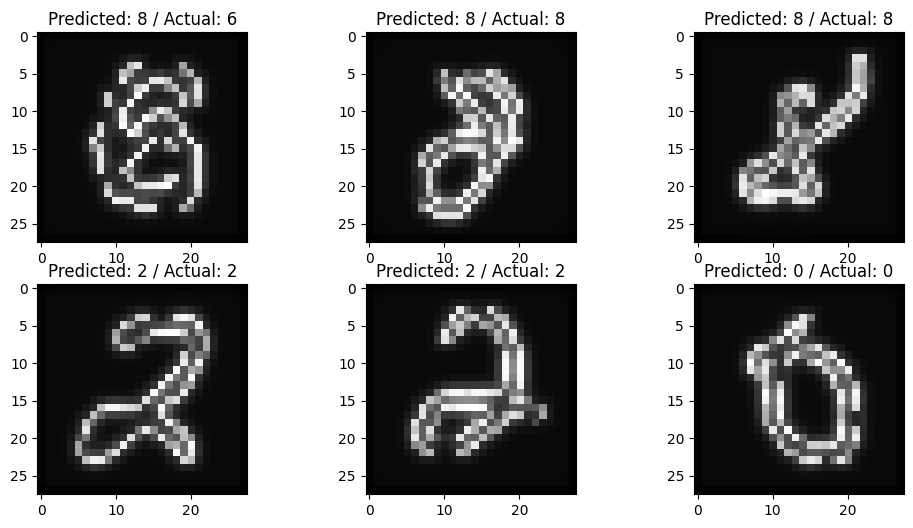

In [ ]:
# 첫 번째 배치에 대한 결과 시각화
images, labels = next(iter(train_loader))
noisy_images = torch.stack([add_salt_and_pepper_noise(img, 0.005, 0.5) for img in images])
denoised_images = torch.stack([mean_field_inference_step(-best_params['unary_potential_strength'] * (img - 0.5).pow(2), best_params['pairwise_potential_strength'], 15) for img in noisy_images])
outputs = model(denoised_images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(denoised_images[i][0], cmap='gray')
    plt.title(f'Predicted: {predicted[i].item()} / Actual: {labels[i].item()}')
plt.show()

# Variational Bayes

|   iter    |  target   |   alpha   |   beta    |  degree   |
-------------------------------------------------------------
| 1         | -0.7464   | 37.41     | 64.82     | 1.569     |
| 2         | -0.6977   | 18.96     | 98.69     | 4.306     |
| 3         | -0.6977   | 74.97     | 62.4      | 4.421     |
| 4         | -0.7464   | 10.53     | 55.23     | 1.155     |
| 5         | -0.6977   | 56.36     | 90.47     | 4.333     |
| 6         | -0.7464   | 52.44     | 39.18     | 1.626     |
| 7         | -0.7049   | 77.33     | 87.16     | 3.278     |
| 8         | -0.7464   | 14.64     | 17.35     | 1.136     |
| 9         | -0.7464   | 66.43     | 85.46     | 1.577     |
| 10        | -0.7464   | 11.82     | 92.78     | 1.034     |
| 11        | -0.6977   | 61.25     | 48.29     | 4.524     |
| 12        | -0.7049   | 30.5      | 53.94     | 3.055     |
| 13        | -0.6977   | 10.32     | 36.78     | 4.448     |
| 14        | -0.7464   | 87.98     | 40.88     | 1.931     |
| 15    

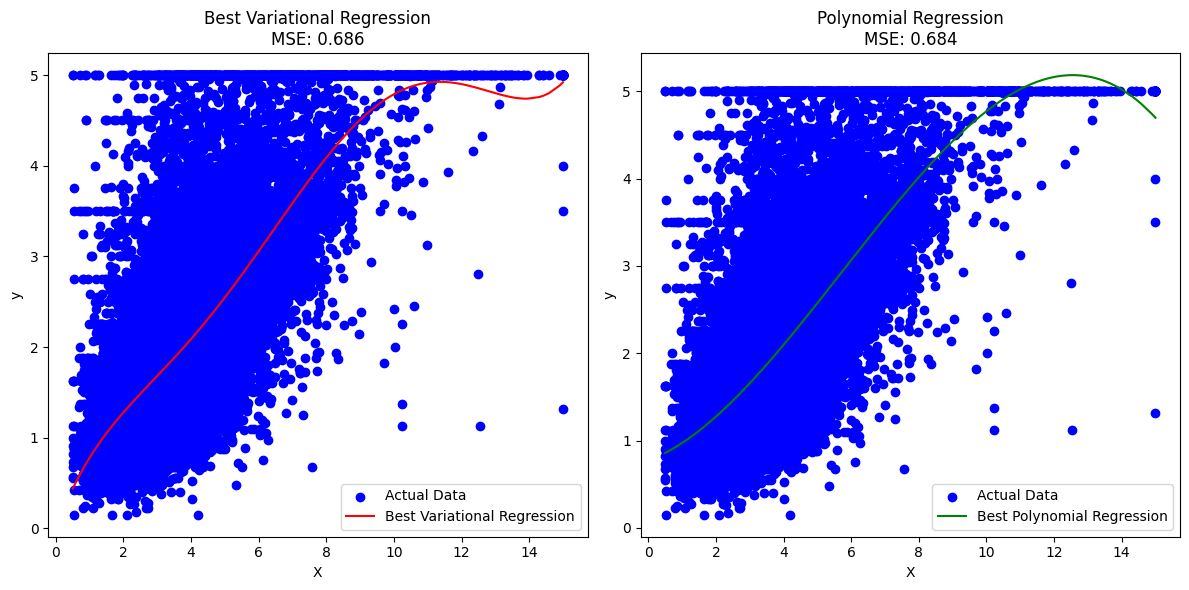

65.04887768703269 72.63777809585599 5
3


In [ ]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.pipeline import make_pipeline

housing = fetch_california_housing()

X = housing.data[:, 0].reshape(-1, 1)
y = housing.target.reshape(-1, 1)

class VariationalRegression:
    def __init__(self, alpha=1.0, beta=1.0, degree=3):
        self.alpha = alpha  # Precision of the prior
        self.beta = beta    # Precision of the noise
        self.degree = degree  # Degree of the polynomial features

    def fit(self, X, y):
        poly_features = PolynomialFeatures(degree=self.degree, include_bias=False)
        X_transformed = poly_features.fit_transform(X)

        n, d = X_transformed.shape
        self.m_n = np.zeros((d, 1))  # Posterior mean 초기화
        self.S_n = np.linalg.inv(self.alpha * np.eye(d) + self.beta * X_transformed.T @ X_transformed)  # Posterior covariance
        self.m_n = self.beta * self.S_n @ X_transformed.T @ y  # Posterior mean

    def predict(self, X):
        poly_features = PolynomialFeatures(degree=self.degree, include_bias=False)
        X_transformed = poly_features.fit_transform(X)

        return X_transformed @ self.m_n

    def get_params(self, deep=True):
        return {'alpha': self.alpha, 'beta': self.beta, 'degree': self.degree}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

def bo_objective(alpha, beta, degree):
    # Variational Regression model
    model = VariationalRegression(alpha=alpha, beta=beta, degree=int(degree))

    model.fit(X, y)

    # Negative MSE를 계산 (Bayesian Optimization의 목적 함수는 maximize를 하는 것이기 때문)
    score = np.mean(cross_val_score(model, X, y.ravel(), cv=3, scoring='neg_mean_squared_error'))

    return score

pbounds = {
    'alpha': (1e-8, 100),
    'beta': (1e-8, 100),
    'degree': (1, 5)
}

# Bayesian Optimization
optimizer = BayesianOptimization(f=bo_objective, pbounds=pbounds)
optimizer.maximize(init_points=50, n_iter=50)

best_params = optimizer.max['params']
best_alpha = best_params['alpha']
best_beta = best_params['beta']
best_degree = int(best_params['degree'])

best_model = VariationalRegression(alpha=best_alpha, beta=best_beta, degree=best_degree)
best_model.fit(X, y)
y_pred_best = best_model.predict(X).ravel()

def grid_search_poly_reg(X, y):
    param_grid = {
        'degree': [i for i in range(1, 6)]
    }

    best_score = float('inf')
    best_params = None

    for degree in param_grid['degree']:
        model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                                LinearRegression())

        score = -np.mean(cross_val_score(model, X, y.ravel(), cv=5, scoring='neg_mean_squared_error'))

        if score < best_score:
            best_score = score
            best_params = {'degree': degree}

    return best_params, best_score

# Grid search with cross-validation
best_params_poly, best_score_poly = grid_search_poly_reg(X, y.ravel())
best_degree_poly = best_params_poly['degree']

# Polynomial Regression model
best_poly_model = make_pipeline(PolynomialFeatures(degree=best_degree_poly, include_bias=False),
                                LinearRegression())
best_poly_model.fit(X, y)
y_pred_best_poly = best_poly_model.predict(X)

mse_best_poly = mean_squared_error(y, y_pred_best_poly)

mse_best_vp = mean_squared_error(y, y_pred_best)

plt.figure(figsize=(12, 6))

# Actual vs. Best Variational Polynomial Regression
plt.subplot(1, 2, 1)
plt.scatter(X, y, color='blue', label='Actual Data')
sorted_indices_vp = X.ravel().argsort()
plt.plot(X[sorted_indices_vp], y_pred_best[sorted_indices_vp], color='red', label='Best Variational Regression')
plt.title(f'Best Variational Regression\nMSE: {mse_best_vp:.3f}')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

# Actual vs. Linear Regression
plt.subplot(1, 2, 2)
plt.scatter(X, y, color='blue', label='Actual Data')
sorted_indices_lr = X.ravel().argsort()
plt.plot(X[sorted_indices_lr], y_pred_best_poly[sorted_indices_lr], color='green', label='Best Polynomial Regression')
plt.title(f'Polynomial Regression\nMSE: {mse_best_poly:.3f}')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

print(best_alpha, best_beta, best_degree)
print(best_degree_poly)